## 16.2 风格迁移
	16.1节已经介绍了利用Deep Dream显示一个卷积网络某一层学习到的一些特征，这些特征从底层到顶层，其抽象程度是不一样的。实际上，这些特征还包括风格（style）等重要信息，风格迁移目前涉及三种风格，具体如下：
- 第一种为普通风格迁移，其特点是固定风格、固定内容，这是一种很经典的风格迁移方法；
- 第二种为快速风格迁移，其特点是固定风格、任意内容；
- 第三种是极速风格迁移，其特点是任意风格、任意内容。
这节我们主要介绍第一种普通风格迁移。
	基于神经网络的普通图像风格迁移是德国的Gatys等人在2015年提出的，其主要原理是将参考图像的风格应用于目标图像，同时保留目标图形的内容，如图16-6所示。

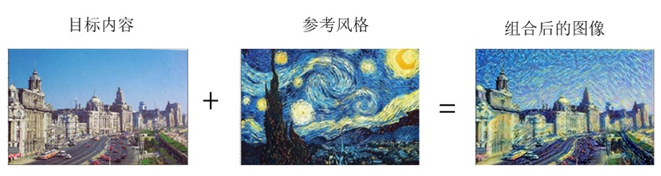
<center>图16-6 一个风格迁移的示例</center>
	实现风格迁移的核心思想就是定义损失函数，所以如何定义损失函数成为解决问题的关键。这个损失函数应该包括内容损失和风格损失，用公式来表示就是：
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
	那么，如何定义内容损失和风格损失呢？这是接下来我们要介绍的内容。

### 16.2.1 内容损失
	由16.1节Deep Dream的实例可以知道，卷积神经网络不同层学到的图像特征是不一样的，靠近底层（或输入端）的卷积层学到的是图像的比较具体、局部的特征，如位置、形状、颜色、纹理等。靠近顶部或输出端的卷积层学到的是图像的更全面、更抽象的特征，但会丢失图像的一些详细信息。基于这个原因，Gatys发现使用靠近底层但不能靠太近的层来衡量图像内容比较理想。图16-7是Gatys使用不同卷积层的特征值，进行内容重建和风格重建的效果对比图。
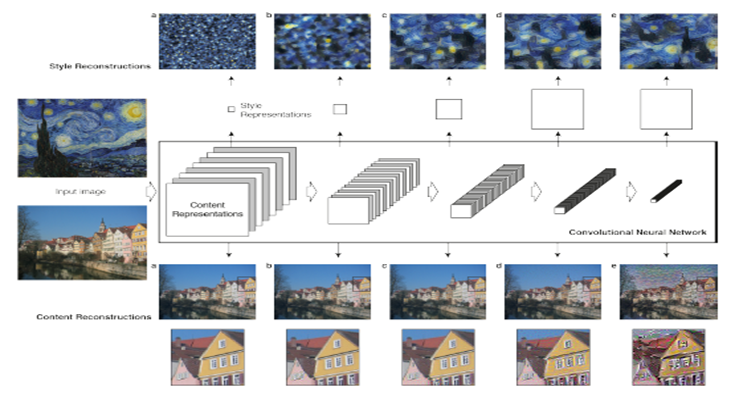
<center>图16-7 使用不同卷积层进行内容重建和风格重建的效果对比图</center>
	对于内容重建来说，使用原始网络的5个卷积层，conv1_1(a)、conv2_1 (b)、conv3_1 (c) conv4_1 (d)和conv5_1(e)，即图下方的a、b、c、d、e。VGG 网络主要用来做内容识别，在实践中作者发现，使用前三层a、b、c已经能够比较好地完成内容重建工作，d、e两层保留了一些比较高层的特征，丢失了一些细节。
使用PyTorch实现内容损失函数的代码如下。

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # # 必须要用detach来分离出target，这时候target不再是一个Variable，
        #这是为了动态计算梯度，否则forward会出错，不能向前传播.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### 16.2.2 风格损失
在图16-7中，我们在进行风格重建时采用了VGG网络中靠近底层的一些卷积层的不同子集： 
‘conv1_1’ (a), 
‘conv1_1’ and ‘conv2_1’ (b), 
‘conv1_1’, ‘conv2_1’ and ‘conv3_1’ (c), 
‘conv1_1’, ‘conv2_1’ , ‘conv3_1’and ‘conv4_1’ (d), 
‘conv1_1’, ‘conv2_1’ , ‘conv3_1’, ‘conv4_1’and ‘conv5_1’ (e)。
靠近底层的卷积层保留了图像的很多纹理、风格信息。由图16-7不难发现d、e效果的更好些。
	如何衡量风格？Gatys采用了基于通道的格拉姆矩阵（Gram Matrix)，即某一层的不同通道的特征图的内积。这个内积可以理解为该层特征之间相互关系的映射，这些关系反映了图像的纹理统计规律。格拉姆矩阵的计算过程如图16-8所示。
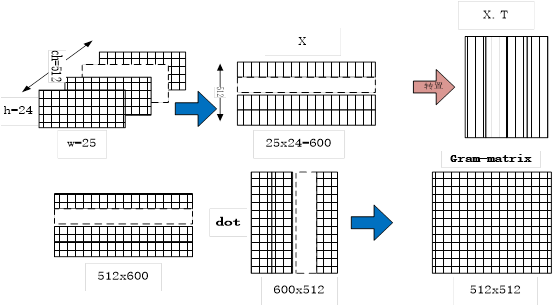
<center>图16-8 格拉姆矩阵的计算过程</center>
假设输入图像经过卷积后，得到的特征图为[ch, h, w],其中ch表示通道数，h、w分别表示特征图的大小。经过展平和矩阵转置操作后，特征图可以变形为[ ch, h*w]和[h*w, ch]的矩阵。再对两个矩阵做内积得到[ch, ch]大小的矩阵，这就是我们所说的格拉姆矩阵，如图16-8中最后一个矩阵。	
注意，图16-8中没有出现批量大小（batch-size），这里假设batch-size=1，如果batch-size大于1，则x矩阵的形状应该是（batch-size*ch，w*h），
使用PyTorch实现风格损失函数的代码如下。


In [3]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a表示批量（batch size）的大小，这里batch size=1
    # b是特征图的数量
    # (c,d)是特征图的维度(N=c*d)

    features = input.view(a * b, c * d)  # 对应图12-5中的x矩阵

    G = torch.mm(features, features.t())  # 计算内积

    # 对格拉姆矩阵标准化
    # 通过对其处以特征图像素总数.
    return G.div(a * b * c * d)

In [4]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### 16.2.3 使用PyTorch实现神经网络风格迁移
	这里使用的预训练模式还是上节使用的VGG19模型，输入数据包括一张代表内容的图像（上海外滩）和一张代表风格的图像（梵高的星空）。以下是主要步骤

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#指定输出图像大小
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu
imsize_w=600

#对图像进行预处理
loader = transforms.Compose([
    transforms.Resize((imsize,imsize_w)),# scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # 增加一个维度，其值为1
    #这是为了满足神经网络对输入图像的形状要求
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./starry-sky.jpg")
content_img = image_loader("./shanghai_buildings.jpg")

print("style size:",style_img.size())
print("content size:",content_img.size())
assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

style size: torch.Size([1, 3, 512, 600])
content size: torch.Size([1, 3, 512, 600])


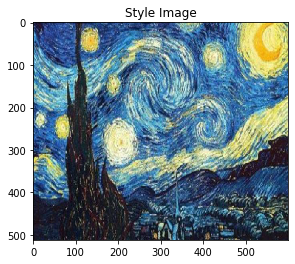

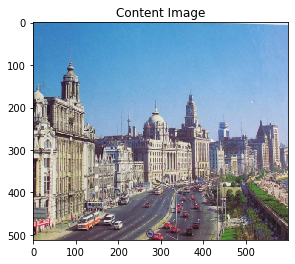

In [7]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # 为避免因image修改影响tensor的值，这里采用clone
    image = image.squeeze(0)      # 去掉批量这个维度
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [9]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [10]:
list(cnn.children())

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1

In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        #self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.mean = mean.clone().detach().view(-1, 1, 1)
        #self.std = torch.tensor(std).view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [12]:
# 为计算内容损失和风格损失，指定使用的卷积层
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # 标准化模型
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # 初始化损失值
    content_losses = []
    style_losses = []

    # 使用sequential方法构建模型
    model = nn.Sequential(normalization)

    i = 0  # 每次迭代增加1
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # 累加内容损失
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # 累加风格损失
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 我们需要对在内容损失和风格损失之后的层进行修剪
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

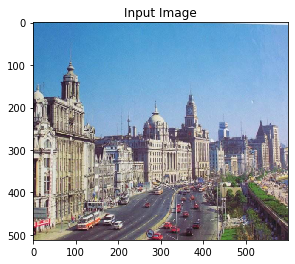

In [13]:
#copy the content_img
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [14]:
def get_input_optimizer(input_img):
    # 这里需要对输入图像进行梯度计算,故需要设置为requires_grad_()，优化方法采用LBFGS
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [15]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=600,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 73.347908 Content Loss: 13.428934

run [100]:
Style Loss : 24.144718 Content Loss: 13.624512

run [150]:
Style Loss : 11.985057 Content Loss: 12.165060

run [200]:
Style Loss : 7.038978 Content Loss: 10.546164

run [250]:
Style Loss : 4.746565 Content Loss: 9.512239

run [300]:
Style Loss : 3.271224 Content Loss: 8.878232

run [350]:
Style Loss : 2.304747 Content Loss: 8.467267

run [400]:
Style Loss : 1.635747 Content Loss: 8.196279

run [450]:
Style Loss : 1.270975 Content Loss: 7.941087

run [500]:
Style Loss : 1.010766 Content Loss: 7.780285

run [550]:
Style Loss : 0.881480 Content Loss: 7.626834

run [600]:
Style Loss : 0.773070 Content Loss: 7.501381



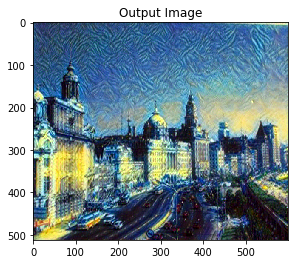

In [16]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()